In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import torch
from torch import nn
import numpy as np
from graphsage.datasets import CenteredGaussianDataset
from graphsage.optimizers import PrecondGD

In [3]:
dataset = CenteredGaussianDataset(w_star=np.ones(2), d = 2, c=np.ones((2, 2)), n=1000)

/home/wilcoln/Workspace/Projects/graphsage/notebooks/../graphsage/utils.py:222: UserWarning: Warning, norms of datapoints are not sqrt(d)
  warnings.warn('Warning, norms of datapoints are not sqrt(d)')


In [4]:
class MLP(nn.Module):
    """
      Multilayer Perceptron for regression.
    """

    def __init__(self, in_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 1),
#             nn.Linear(in_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
        )

    def forward(self, x):
        """
          Forward pass
        """
        return self.layers(x)

In [5]:
NB_EPOCHS = 100
# Set fixed random number seed
torch.manual_seed(0)
# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create trainloader object
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)

# Create testloader object
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP(in_size=dataset.X.shape[1])

# Define the loss function and optimizer
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
optimizer = PrecondGD(mlp.parameters(), lr=1e-4)


losses = {'train': [], 'test': []}
epochs = range(NB_EPOCHS)


def train(epoch):
     # Print epoch
#     print(f'Starting epoch {epoch + 1}')

    mlp.train()
    
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(trainloader)
    
    losses['train'].append(current_loss)
    
#     print('Train Loss: %.3f'%(current_loss))

    
def test(epoch):
    mlp.eval()

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(testloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(testloader)
    
    losses['test'].append(current_loss)
    
#     print('Test Loss: %.3f'%(current_loss))

In [6]:
# Run the training loop
for epoch in epochs:
    train(epoch)
    test(epoch)

/home/wilcoln/Workspace/Projects/graphsage/notebooks/../graphsage/optimizers.py:48: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  p.data.add_(-group['lr'], d_p)


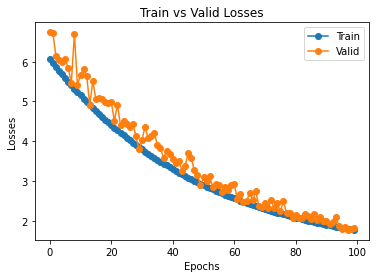

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses['train'], '-o')
plt.plot(losses['test'], '-o')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()